# Project T21 RNA-seq data

Project T21 RNA-seq data to Multiplier model and study differential LVs between affected (T21) and control (D21) samples.

# Load libraries/modules

In [15]:
library(biomaRt)
library(here)
library(biomaRt)
library(DESeq2)
library(tidyverse)
library(rtracklayer)
library(dplyr)
library(GenomicRanges)
library(ggpubr)
library(cowplot)
# load plier utils
source(here::here('scripts/plier_util.R'))

# Load data

In [16]:
# define output nb
output_nb_path = here('output/nbs/project_T21_rnaseq_data')
dir.create(output_nb_path, showWarnings = FALSE)

counts_matrix=here::here('data/GSE151282/GSE151282_Raw_gene_counts_matrix.txt')

# multiplier model
multiplier_z = readRDS(here('data/multiplier/multiplier_model_z.rds'))
multiplier_summary = readRDS(here('data/multiplier/multiplier_model_summary.rds'))
multiplier_b = readRDS(here('data/multiplier/multiplier_model_b.rds'))
multiplier_metadata = readRDS(here('data/multiplier/multiplier_model_metadata.rds'))
multiplier_U = readRDS(here('data/multiplier/multiplier_model_u.rds'))

# TPM Normalization Process

TPM (Transcripts Per Kilobase Million) is a method for normalizing RNA sequencing data. It helps in comparing gene expression levels across different samples. The steps to compute TPM are as follows:

1. **Load the Data**: Import your gene count data into R.
2. **Calculate Gene Lengths**: Obtain or calculate the length of each gene in kilobases. This data is necessary for the normalization process.
3. **Compute Scaled Reads**: Divide each gene's read count by its length in kilobases to account for gene length and get scaled reads.
4. **Sum Scaled Reads**: Calculate the sum of all the scaled reads across all genes in a sample. This sum will be used to normalize the read counts so that they are comparable across samples.
5. **Calculate TPM**: Normalize each gene's scaled reads by the sum of scaled reads across all genes and multiply by 1,000,000. This final step adjusts for the total amount of transcript in each sample, allowing for comparisons across samples.


# GSE151282 RNA-seq analysis

- The transcriptome profile of human trisomy 21 blood cells
- Antonaros, F., Zenatelli, R., Guerri, G. et al. The transcriptome profile of human trisomy 21 blood cells. Hum Genomics 15, 25 (2021). https://doi.org/10.1186/s40246-021-00325-4
- Human blood cell RNA-Seq
- 4 T21
- 4 D21

In [17]:
gene_counts_GSE151282 <- read.table(counts_matrix, header = TRUE, sep = "\t", check.names = FALSE)
head(gene_counts_GSE151282)

,Geneid,GeneSymbol,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000223972,DDX11L1,0,1,3,0,0,1,3,1
2,ENSG00000227232,WASH7P,12,56,21,6,1,1,11,3
3,ENSG00000278267,MIR6859-1,0,2,3,1,0,0,2,1
4,ENSG00000243485,MIR1302-2HG,0,0,0,0,0,0,0,0
5,ENSG00000284332,MIR1302-2,0,0,0,0,0,0,0,0
6,ENSG00000237613,FAM138A,0,0,0,1,0,0,0,0


In [18]:
gene_counts=gene_counts_GSE151282
head(gene_counts)
head(gtf_path)

,Geneid,GeneSymbol,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000223972,DDX11L1,0,1,3,0,0,1,3,1
2,ENSG00000227232,WASH7P,12,56,21,6,1,1,11,3
3,ENSG00000278267,MIR6859-1,0,2,3,1,0,0,2,1
4,ENSG00000243485,MIR1302-2HG,0,0,0,0,0,0,0,0
5,ENSG00000284332,MIR1302-2,0,0,0,0,0,0,0,0
6,ENSG00000237613,FAM138A,0,0,0,1,0,0,0,0


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'gtf_path' not found


In [19]:
gtf_path <- here::here('data/GCF_000001405.38_GRCh38.p12_genomic.gtf')
tpm_gene_counts_GSE151282=tpm_normalization(gene_counts_GSE151282, gtf_path)
head(tpm_gene_counts_GSE151282)

Joining with `by = join_by(GeneSymbol)`


,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
DDX11L1,0.0000000,0.0894938,0.2321369,0.00000000,0.000000000,0.049095538,0.13955746,0.05185053
WASH7P,0.2340089,0.8465178,0.2744716,0.08385476,0.007722642,0.008292723,0.08643301,0.02627421
MIR6859.1,0.0000000,6.7721425,8.7830902,3.13057782,0.000000000,0.000000000,3.52018064,1.96180738
MIR1302.2HG,0.0000000,0.0000000,0.0000000,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000
MIR1302.2,0.0000000,0.0000000,0.0000000,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000
FAM138A,0.0000000,0.0000000,0.0000000,0.14268620,0.000000000,0.000000000,0.00000000,0.00000000


# Multiplier projection

In [20]:
multiplier_model = list('Z'=multiplier_z, 'L2'= multiplier_metadata$L2, 'B'=multiplier_b, 'U'=multiplier_U)

In [21]:
result_GetOrderedRowNormEM <- GetOrderedRowNormEM(tpm_gene_counts_GSE151282, multiplier_model)
ordered_tpm_gene_counts_GSE151282 = result_GetOrderedRowNormEM$exprs.norm.filtered
ordered_multiplier_model = result_GetOrderedRowNormEM$plier.model

head(ordered_tpm_gene_counts_GSE151282)
head(ordered_multiplier_model$Z)

,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
NOC2L,0.6174599,1.6425985,0.77679955,0.4719270,-0.97073166,-0.8561426,-0.79212548,-0.8897853
HES4,0.6887493,2.1251224,-0.84268842,-0.8426884,-0.53945012,-0.5170652,0.08291795,-0.1548974
ISG15,2.4165907,-0.1183297,-0.50614670,-0.1136030,-0.08082541,-0.6019605,-0.41920696,-0.5765184
AGRN,1.1376288,1.8609427,0.05741559,-0.1041626,-0.56033097,-0.7717821,-0.74987413,-0.8698373
TNFRSF18,0.5938318,2.2526853,-0.25348261,-0.6202730,-0.82341560,-0.3412662,-0.36656795,-0.4415117
TNFRSF4,0.6852642,1.7872640,-0.01884701,0.8129952,-0.84879276,-0.7458437,-0.84584812,-0.8261918


NOC2L,2.23797023,0.00000000,0.112685524,0.00000000,0.000000000,0.00000000,0,0,0.42079364,0.0000000,⋯,0.00000000,0.08177377,0.07962461,0.000000000,0,0.000000000,0.43284712,0.00000000,0.00000000,0.0000000
HES4,0.26999934,0.08490505,0.000000000,0.05744514,0.013894115,0.76790870,0,0,1.70535493,0.0000000,⋯,0.00000000,0.00000000,0.05260650,0.014124645,0,0.000000000,0.57737279,0.08543191,0.00000000,0.0000000
ISG15,0.03686669,0.00000000,0.000000000,0.04568015,0.004998977,0.00000000,0,0,0.23015827,0.1165996,⋯,0.00000000,0.00000000,0.00000000,0.018421383,0,0.003058988,0.00000000,0.00000000,0.00000000,0.0000000
AGRN,0.43266367,0.00000000,0.010172089,0.00000000,0.025733268,0.00000000,0,0,0.09382693,0.0930792,⋯,0.00000000,0.00000000,0.00000000,0.000000000,0,0.000000000,0.38517356,0.06212099,0.00000000,0.1202636
TNFRSF18,0.01226595,0.00000000,0.003937571,0.00000000,0.017390170,0.08748055,0,0,0.07813778,0.0000000,⋯,0.02974547,0.02527198,0.00000000,0.008847392,0,0.008247321,0.03988636,0.00000000,0.00000000,0.0000000
TNFRSF4,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0,0,0.41229068,0.0000000,⋯,0.00000000,0.09573129,0.00000000,0.025296539,0,0.000000000,0.00000000,0.00000000,0.01924974,0.0000000


In [22]:
projection_GSE151282 <-  GetNewDataB(ordered_tpm_gene_counts_GSE151282, ordered_multiplier_model)
head(projection_GSE151282)

,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
"1,REACTOME_MRNA_SPLICING",-0.026318078,0.06145420,0.011525707,0.184757951,-0.01845054,-0.070357926,-0.054525362,-0.088085944
"2,SVM Monocytes",0.036208297,0.18198135,-0.032589538,-0.079208460,-0.02288641,-0.019616545,-0.033563073,-0.030325616
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",0.013594587,0.08547574,0.036401351,0.010737753,-0.03957537,-0.043117196,-0.020358955,-0.043157917
"4,REACTOME_NEURONAL_SYSTEM",0.002833815,0.03284135,0.040269087,-0.031094299,-0.03377510,0.015996659,-0.008314205,-0.018757312
LV 5,-0.015823665,0.04365339,0.073584457,-0.021515534,-0.04625251,-0.013057946,0.004891599,-0.025479794
LV 6,0.003273767,0.01989563,0.003527031,-0.007582424,-0.01789218,0.007342733,-0.006843828,-0.001720723


In [23]:
df_projection_GSE151282 <- data.frame(projection_GSE151282) %>%
  dplyr::mutate(LV = rownames(projection_GSE151282)) %>%
  dplyr::select(LV, everything()) %>%
  `rownames<-`(1:nrow(projection_GSE151282))

head(df_projection_GSE151282)

,LV,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"1,REACTOME_MRNA_SPLICING",-0.026318078,0.06145420,0.011525707,0.184757951,-0.01845054,-0.070357926,-0.054525362,-0.088085944
2,"2,SVM Monocytes",0.036208297,0.18198135,-0.032589538,-0.079208460,-0.02288641,-0.019616545,-0.033563073,-0.030325616
3,"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",0.013594587,0.08547574,0.036401351,0.010737753,-0.03957537,-0.043117196,-0.020358955,-0.043157917
4,"4,REACTOME_NEURONAL_SYSTEM",0.002833815,0.03284135,0.040269087,-0.031094299,-0.03377510,0.015996659,-0.008314205,-0.018757312
5,LV 5,-0.015823665,0.04365339,0.073584457,-0.021515534,-0.04625251,-0.013057946,0.004891599,-0.025479794
6,LV 6,0.003273767,0.01989563,0.003527031,-0.007582424,-0.01789218,0.007342733,-0.006843828,-0.001720723


In [24]:
# Transpose Data for Analysis
lv_data_long <- df_projection_GSE151282 %>% 
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
  mutate(Group = ifelse(str_detect(Sample, "A[0-9]_T21"), "T21", "N"))

head(lv_data_long)

LV,Sample,Value,Group
<chr>,<chr>,<dbl>,<chr>
"1,REACTOME_MRNA_SPLICING",A2_T21,-0.02631808,T21
"1,REACTOME_MRNA_SPLICING",A1_T21,0.06145420,T21
"1,REACTOME_MRNA_SPLICING",B1_N,0.01152571,N
"1,REACTOME_MRNA_SPLICING",B2_N,0.18475795,N
"1,REACTOME_MRNA_SPLICING",A3_T21,-0.01845054,T21
"1,REACTOME_MRNA_SPLICING",A4_T21,-0.07035793,T21


In [25]:
# Transpose Data for Analysis
lv_data_long <- df_projection_GSE151282 %>% 
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
  mutate(Group = ifelse(str_detect(Sample, "A[0-9]_T21"), "T21", "N"))

# Function to Perform t-test for each LV
t_test_results <- lv_data_long %>%
  group_by(LV) %>%
  summarise(p_value = t.test(Value ~ Group)$p.value)

# Multiple Testing Correction (FDR)
t_test_results <- t_test_results %>%
  mutate(p_adjusted = p.adjust(p_value, method = "fdr"))

t_test_results %>% 
    arrange(p_value) %>% 
    head()

LV,p_value,p_adjusted
<chr>,<dbl>,<dbl>
LV 481,0.01233781,0.9970931
LV 219,0.02592792,0.9970931
LV 737,0.04010704,0.9970931
"26,SVM Macrophages M2",0.05340880,0.9970931
"707,REACTOME_PEPTIDE_CHAIN_ELONGATION",0.05978140,0.9970931
LV 281,0.06354939,0.9970931


In [26]:
df_ordered_multiplier_modelZ <- as.data.frame(as.matrix(ordered_multiplier_model$Z)) %>%
  `colnames<-`(paste0("LV", seq_len(ncol(.)))) 
head(df_ordered_multiplier_modelZ)

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NOC2L,2.23797023,0.00000000,0.112685524,0.00000000,0.000000000,0.00000000,0,0,0.42079364,0.0000000,⋯,0.00000000,0.08177377,0.07962461,0.000000000,0,0.000000000,0.43284712,0.00000000,0.00000000,0.0000000
HES4,0.26999934,0.08490505,0.000000000,0.05744514,0.013894115,0.76790870,0,0,1.70535493,0.0000000,⋯,0.00000000,0.00000000,0.05260650,0.014124645,0,0.000000000,0.57737279,0.08543191,0.00000000,0.0000000
ISG15,0.03686669,0.00000000,0.000000000,0.04568015,0.004998977,0.00000000,0,0,0.23015827,0.1165996,⋯,0.00000000,0.00000000,0.00000000,0.018421383,0,0.003058988,0.00000000,0.00000000,0.00000000,0.0000000
AGRN,0.43266367,0.00000000,0.010172089,0.00000000,0.025733268,0.00000000,0,0,0.09382693,0.0930792,⋯,0.00000000,0.00000000,0.00000000,0.000000000,0,0.000000000,0.38517356,0.06212099,0.00000000,0.1202636
TNFRSF18,0.01226595,0.00000000,0.003937571,0.00000000,0.017390170,0.08748055,0,0,0.07813778,0.0000000,⋯,0.02974547,0.02527198,0.00000000,0.008847392,0,0.008247321,0.03988636,0.00000000,0.00000000,0.0000000
TNFRSF4,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0,0,0.41229068,0.0000000,⋯,0.00000000,0.09573129,0.00000000,0.025296539,0,0.000000000,0.00000000,0.00000000,0.01924974,0.0000000


In [27]:
df_ordered_multiplier_modelZ[c("LV26")] %>% 
    dplyr::arrange(desc(LV26)) %>% 
    head(10)

,LV26
,<dbl>
CCL18,6.342055
CCL23,6.144151
CD209,5.832267
CLEC10A,5.338751
ALOX15,5.022820
CLEC4A,4.229976
DNASE1L3,4.100035
C1QC,3.023242
CD1A,2.797564


In [28]:
head(ordered_multiplier_model$B)

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,⋯,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
"1,REACTOME_MRNA_SPLICING",-0.059296689,-0.047909034,-0.049366085,-0.065078034,-0.036394186,-0.046432986,-0.040980500,-0.040068202,-0.046137392,-0.048547681,⋯,0.028219530,0.035137107,0.065077330,0.078143650,0.092361864,0.069042346,0.090913845,0.096341467,0.13111465,0.171751422
"2,SVM Monocytes",0.006212678,0.003625471,0.006604582,0.009258006,0.005061427,0.004132735,0.008950264,0.007226716,0.007240987,0.005709697,⋯,-0.050455152,-0.034501970,-0.033640290,-0.049702173,-0.037425739,-0.050069528,-0.022575052,-0.055091302,-0.05686929,-0.018072570
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.026105335,-0.032232060,-0.020621382,-0.027598555,-0.035248076,-0.038700769,-0.032527087,-0.030592727,-0.028937277,-0.027405660,⋯,-0.028609689,-0.033449754,-0.030583001,-0.032399106,-0.029365381,-0.025405876,-0.033657228,-0.031317680,-0.03092424,-0.027868614
"4,REACTOME_NEURONAL_SYSTEM",-0.022079745,-0.008970910,-0.020341711,-0.016260213,-0.003022898,0.002442659,-0.020457842,-0.023735309,-0.021581483,-0.022477572,⋯,-0.037122216,-0.029658154,-0.036349546,-0.039253549,-0.035204624,-0.036345061,-0.034513880,-0.035925708,-0.04035837,-0.031131153
LV 5,0.007663157,0.007036176,0.006608393,0.003446311,0.006340665,0.007106127,0.007930485,0.009164026,0.008023601,0.007937586,⋯,-0.003055909,-0.004783739,-0.004352417,-0.004159541,-0.001084991,-0.001884109,-0.003561052,-0.003546184,-0.01210732,-0.001192709
LV 6,0.003014322,0.002005692,0.007768482,-0.004943417,0.019649274,0.003509484,0.008170202,0.009434190,0.007881926,0.007861974,⋯,-0.042169397,-0.051798302,-0.045170871,-0.048687711,-0.038200131,-0.046747069,-0.042864145,-0.032012738,-0.02439828,-0.062237591


In [29]:
int_lvs = c(481,
            219,
            737,
            26,
            707,
            281)

multiplier_summary %>% 
dplyr::filter(`LV index` %in% int_lvs) %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7)

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
IRIS_DendriticCell-Control,26,0.7741243,8.082947e-14,6.226756e-12
SVM Macrophages M2,26,0.7896932,5.503019e-04,4.600780e-03
SVM Dendritic cells resting,26,0.9803279,3.743382e-09,1.062431e-07
REACTOME_PEPTIDE_CHAIN_ELONGATION,707,0.9997656,1.032655e-15,1.012472e-13
KEGG_RIBOSOME,707,0.9566363,2.047765e-13,1.472343e-11
MIPS_40S_RIBOSOMAL_SUBUNIT_CYTOPLASMIC,707,0.9977679,6.831719e-07,1.351928e-05
MIPS_RIBOSOME_CYTOPLASMIC,707,0.9995303,7.948872e-15,7.144049e-13
REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S,707,0.8645801,8.299737e-07,1.612841e-05


# GSE190125 RNA-seq analysis

- Multidimensional definition of the interferonopathy of Down syndrome and its response to JAK inhibitionGalbraith, M. D., Rachubinski, A. L., Smith, K. P., Araya, P., Waugh, K. A., Enriquez-Estrada, B., Worek, K., Granrath, R. E., Kinning, K. T., Paul Eduthan, N., Ludwig, M. P., Hsieh, E. W. Y., Sullivan, K. D., & Espinosa, J. M. (2023). Multidimensional definition of the interferonopathy of Down syndrome and its response to JAK inhibition. In Science Advances (Vol. 9, Issue 26). American Association for the Advancement of Science (AAAS). https://doi.org/10.1126/sciadv.adg6218Human
- Blood cell RNA-Seq
- T21 304
- D21 96


In [109]:
counts_matrix=here::here('data/GSE190125/GSE190125_Counts_for_GEO.txt')
raw_gene_counts_GSE190125 <- read.table(counts_matrix, header = TRUE, sep = "\t", check.names = FALSE)
head(raw_gene_counts_GSE190125)

,SampleID,EnsemblID,gene_name,chr,gene_type,raw_count
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,HTP0001B2,ENSG00000121410.12,A1BG,chr19,protein_coding,25
2,HTP0001B2,ENSG00000268895.6,A1BG-AS1,chr19,lncRNA,378
3,HTP0001B2,ENSG00000148584.15,A1CF,chr10,protein_coding,1
4,HTP0001B2,ENSG00000175899.14,A2M,chr12,protein_coding,6
5,HTP0001B2,ENSG00000245105.4,A2M-AS1,chr12,lncRNA,64
6,HTP0001B2,ENSG00000166535.20,A2ML1,chr12,protein_coding,0


In [110]:
gene_counts_GSE190125 <- raw_gene_counts_GSE190125 %>%
 dplyr::select(-chr, -gene_type) %>%
  pivot_wider(
    names_from = SampleID,
    values_from = raw_count,
    values_fill = list(raw_count = 0)
  ) %>%
  dplyr::select(Geneid = EnsemblID, GeneSymbol = gene_name, everything())

head(gene_counts_GSE190125)

Geneid,GeneSymbol,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000121410.12,A1BG,25,19,13,7,28,17,23,21,⋯,6,13,7,10,28,22,18,30,10,23
ENSG00000268895.6,A1BG-AS1,378,305,275,124,240,176,469,229,⋯,363,447,225,261,391,308,226,292,253,314
ENSG00000148584.15,A1CF,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000175899.14,A2M,6,11,4,11,16,4,39,11,⋯,9,15,12,18,4,7,18,8,1,12
ENSG00000245105.4,A2M-AS1,64,77,47,113,51,55,133,64,⋯,41,23,45,93,53,61,29,97,38,78
ENSG00000166535.20,A2ML1,0,0,1,0,0,3,0,1,⋯,2,0,0,0,0,0,0,0,1,0


In [111]:
tpm_gene_counts_GSE190125=tpm_normalization(gene_counts_GSE190125, gtf_path)
head(tpm_gene_counts_GSE190125)

ERROR: No module named '/home/msubirana/Documents/pivlab/plier_recount3/data/GCF_000001405'

In [ ]:
path_metadata_GSE190125 <- here::here('data/GSE190125/metadata_GSE190125.csv')
metadata_GSE190125 <- read.csv(path_metadata_GSE190125)
colnames(metadata_GSE190125) <- c('Group', 'Sample')	
head(metadata_GSE190125)

In [ ]:
result_GetOrderedRowNormEM <- GetOrderedRowNormEM(tpm_gene_counts_GSE190125, multiplier_model)
ordered_tpm_gene_counts_GSE190125 = result_GetOrderedRowNormEM$exprs.norm.filtered
ordered_multiplier_model = result_GetOrderedRowNormEM$plier.model

head(ordered_tpm_gene_counts_GSE190125)
head(ordered_multiplier_model$Z)

In [ ]:
projection_GSE190125 <-  GetNewDataB(ordered_tpm_gene_counts_GSE190125, ordered_multiplier_model)
head(projection_GSE190125)

In [55]:
df_projection_GSE190125 <- data.frame(projection_GSE190125)

In [56]:
saveRDS(df_projection_GSE190125, file.path(output_nb_path, 'projection_GSE190125.rds'))

In [57]:
library(reticulate)

save_as_pickle <- function(object, filename, save_directory) {
  full_path <- file.path(save_directory, filename)
  py_save_object(r_to_py(object), full_path)
}

save_as_pickle(df_projection_GSE190125, 'projection_GSE190125.pkl', output_nb_path)

In [36]:
df_projection_GSE190125 <- data.frame(projection_GSE190125) %>%
  dplyr::mutate(LV = rownames(projection_GSE190125)) %>%
  dplyr::select(LV, everything()) %>%
  `rownames<-`(1:nrow(projection_GSE190125))

head(df_projection_GSE190125)

,LV,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,HTP0023A2,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"1,REACTOME_MRNA_SPLICING",-0.06099632,-0.01430609,-0.03130548,-0.074037007,-0.048863872,-0.114502320,-0.11421761,-0.04892442,0.059415268,⋯,0.080103354,0.017802191,0.04655742,0.15552108,0.051443243,-0.002789900,-0.11195683,-0.103051713,-0.21621076,-0.02468260
2,"2,SVM Monocytes",-0.08146227,-0.05536597,-0.02972342,-0.039475088,-0.110519728,0.009648965,0.13449292,-0.09065066,-0.104384092,⋯,0.063808707,0.214577677,0.06508193,-0.10209963,-0.015714285,0.076125180,-0.03852608,-0.088829773,0.13580746,-0.04390065
3,"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.02262647,0.04484774,0.03568434,-0.024717313,0.027683259,-0.015442372,-0.03803203,0.02723657,0.052669709,⋯,-0.007349750,-0.051454897,0.01547555,0.06168419,-0.052080550,-0.018102595,-0.10253309,-0.049551978,-0.09978477,-0.04098150
4,"4,REACTOME_NEURONAL_SYSTEM",0.05196313,0.06577709,0.04380500,0.040477015,0.009822520,0.180213572,0.12401270,0.06206372,0.018866738,⋯,-0.055041745,-0.029739440,-0.05490456,-0.04396545,-0.005205959,-0.008701111,-0.04489926,0.073023994,-0.01055307,-0.03018856
5,LV 5,0.04947318,0.01245486,-0.02527954,-0.003544312,-0.006318418,0.070618180,0.04279276,0.02319721,0.008408280,⋯,-0.009392844,-0.021003309,-0.03397902,0.04592781,-0.032247435,0.049246856,0.04562237,-0.015651993,-0.01902293,-0.02628829
6,LV 6,0.01980925,0.01853340,0.02602953,0.008319347,-0.001567239,0.055275479,0.03312572,0.08031698,-0.001628834,⋯,-0.003010193,-0.000987795,0.02034803,0.01559351,0.011894298,0.018546133,0.01709347,-0.007142013,0.01443277,-0.02684721


In [37]:
# Transpose Data for Analysis
lv_data_long <- df_projection_GSE190125 %>% 
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
    dplyr::left_join(metadata_GSE190125)

# Function to Perform t-test for each LV
t_test_results <- lv_data_long %>%
  group_by(LV) %>%
  summarise(p_value = t.test(Value ~ Group)$p.value)

# Multiple Testing Correction (FDR)
t_test_results <- t_test_results %>%
  mutate(p_adjusted = p.adjust(p_value, method = "fdr"))

sig_t_test_results <-  t_test_results %>% 
    arrange(p_value) %>% 
    dplyr::filter(p_adjusted < 0.05)

head(sig_t_test_results)

Joining with `by = join_by(Sample)`


LV,p_value,p_adjusted
<chr>,<dbl>,<dbl>
LV 338,5.498213e-38,5.426737e-35
LV 967,1.724775e-30,8.511766e-28
LV 875,4.760238e-30,1.566118e-27
LV 149,2.370182e-28,4.484793e-26
LV 439,2.952776e-28,4.484793e-26
LV 52,3.042914e-28,4.484793e-26


In [38]:
top_int_lvs <-  str_extract(sig_t_test_results$LV, "\\d+")
top_int_lvs <- unique(top_int_lvs)
head(top_int_lvs)

[1] "338" "967" "875" "149" "439" "52"

In [39]:
multiplier_summary %>% 
dplyr::filter(`LV index` %in% top_int_lvs) %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7)

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES,3,0.7823614,9.532254e-08,2.164323e-06
PID_RAC1_REG_PATHWAY,4,0.7551066,4.924915e-03,2.649138e-02
PID_ERBB1_INTERNALIZATION_PATHWAY,4,0.7444768,6.725439e-03,3.397370e-02
IRIS_Neutrophil-Resting,7,0.7006335,6.673189e-11,2.937565e-09
PID_IL8CXCR2_PATHWAY,7,0.7242235,1.057905e-02,4.928513e-02
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,7,0.7075224,2.881284e-03,1.731178e-02
KEGG_PPAR_SIGNALING_PATHWAY,8,0.7898987,2.221298e-04,2.170448e-03
IRIS_Monocyte-Day1,10,0.7172650,6.596666e-11,2.937565e-09
IRIS_Monocyte-Day7,10,0.7754324,1.400212e-15,1.313155e-13


In [62]:
multiplier_summary %>% 
dplyr::filter(`LV index` %in% top_int_lvs) %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7) %>% 
arrange(match(`LV index`, top_int_lvs))

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
PID_AR_NONGENOMIC_PATHWAY,338,0.7515377,1.037288e-02,4.874576e-02
REACTOME_FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX,310,0.7516784,1.039316e-03,7.901466e-03
DMAP_MEGA2,264,0.8578451,5.927467e-06,9.332515e-05
REACTOME_CHROMOSOME_MAINTENANCE,92,0.7345132,5.753136e-05,6.856085e-04
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,749,0.7697398,2.055836e-03,1.368654e-02
REACTOME_COLLAGEN_FORMATION,671,0.8873401,5.995466e-06,9.371174e-05
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,671,0.9817055,3.625550e-11,1.777343e-09
IRIS_Monocyte-Day1,10,0.7172650,6.596666e-11,2.937565e-09
IRIS_Monocyte-Day7,10,0.7754324,1.400212e-15,1.313155e-13


In [89]:
lv_index_vector <- multiplier_summary %>%
  dplyr::filter(`LV index` %in% top_int_lvs) %>%
  dplyr::filter(FDR < 0.05 & AUC > 0.7) %>%
  arrange(match(`LV index`, top_int_lvs)) %>%
  dplyr::select(`LV index`) %>%
  unique() %>%
  dplyr::pull(`LV index`)

lv_index_vector <- c(lv_index_vector)
lv_index_vector<-  as.numeric(lv_index_vector)
first_10_lv_indices <- c(lv_index_vector[1:10])

first_10_lv_indices

[1] 338 310 264  92 749 671  10 898  81 928

In [107]:
data.frame(multiplier_model$Z)%>% 
    dplyr::select(X898) %>%
    dplyr::mutate(X898=as.numeric(X898)) %>%  
    dplyr::arrange(desc(X898)) %>% 
    dplyr::filter(X898 > 1) %>% 
    rownames() %>% 
    print()

 [1] "NAPSB"     "FCRL5"     "IL4R"      "BLK"       "BMF"       "FCRL2"    
 [7] "LILRA4"    "IGHM"      "CD37"      "CD79A"     "SPIB"      "CARD11"   
[13] "FCRLA"     "CNR2"      "BTLA"      "BCL2"      "FCRL1"     "FAM129C"  
[19] "PAX5"      "GGA2"      "SH3BP5"    "KCNN4"     "IL24"      "FCER2"    
[25] "KLHL14"    "CD74"      "SLC9A7"    "IRF8"      "NFATC1"    "ARHGAP44" 
[31] "CBFA2T3"   "KLF8"      "IKZF3"     "PNOC"      "PLEKHG1"   "CD19"     
[37] "P2RY10"    "KIAA0040"  "SYK"       "ST6GAL1"   "CXCR4"     "FCGR2B"   
[43] "APOBEC3G"  "MAP3K14"   "SEMA4B"    "CD27"      "MAP3K1"    "LAPTM5"   
[49] "CD79B"     "TLR9"      "SPOCK2"    "RALGPS2"   "RBM38"     "ZBTB32"   
[55] "CIITA"     "GRB2"      "C11orf80"  "PRKCE"     "IL10RA"    "WDR11"    
[61] "ABCA6"     "TNFRSF13C" "RHOBTB2"   "POU2F2"    "ADAM28"    "SP140"    
[67] "ARHGAP17"  "RHOH"      "CHST2"     "ICOSLG"    "CXCR5"     "PRKCB"    
[73] "OSBPL10"   "ZFPM1"     "TADA2B"    "RAPGEF1"  


In [41]:
head(ordered_multiplier_model$B)

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,⋯,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
"1,REACTOME_MRNA_SPLICING",-0.059296689,-0.047909034,-0.049366085,-0.065078034,-0.036394186,-0.046432986,-0.040980500,-0.040068202,-0.046137392,-0.048547681,⋯,0.028219530,0.035137107,0.065077330,0.078143650,0.092361864,0.069042346,0.090913845,0.096341467,0.13111465,0.171751422
"2,SVM Monocytes",0.006212678,0.003625471,0.006604582,0.009258006,0.005061427,0.004132735,0.008950264,0.007226716,0.007240987,0.005709697,⋯,-0.050455152,-0.034501970,-0.033640290,-0.049702173,-0.037425739,-0.050069528,-0.022575052,-0.055091302,-0.05686929,-0.018072570
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.026105335,-0.032232060,-0.020621382,-0.027598555,-0.035248076,-0.038700769,-0.032527087,-0.030592727,-0.028937277,-0.027405660,⋯,-0.028609689,-0.033449754,-0.030583001,-0.032399106,-0.029365381,-0.025405876,-0.033657228,-0.031317680,-0.03092424,-0.027868614
"4,REACTOME_NEURONAL_SYSTEM",-0.022079745,-0.008970910,-0.020341711,-0.016260213,-0.003022898,0.002442659,-0.020457842,-0.023735309,-0.021581483,-0.022477572,⋯,-0.037122216,-0.029658154,-0.036349546,-0.039253549,-0.035204624,-0.036345061,-0.034513880,-0.035925708,-0.04035837,-0.031131153
LV 5,0.007663157,0.007036176,0.006608393,0.003446311,0.006340665,0.007106127,0.007930485,0.009164026,0.008023601,0.007937586,⋯,-0.003055909,-0.004783739,-0.004352417,-0.004159541,-0.001084991,-0.001884109,-0.003561052,-0.003546184,-0.01210732,-0.001192709
LV 6,0.003014322,0.002005692,0.007768482,-0.004943417,0.019649274,0.003509484,0.008170202,0.009434190,0.007881926,0.007861974,⋯,-0.042169397,-0.051798302,-0.045170871,-0.048687711,-0.038200131,-0.046747069,-0.042864145,-0.032012738,-0.02439828,-0.062237591


In [113]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 250)

PLIER::plotU(plierRes = ordered_multiplier_model,
             indexCol = first_10_lv_indices,
             top = 10)

Warning message in max(plierRes$summary[plierRes$summary[, 5] < fdr.cutoff, 4]):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in 1:ncol(U): argument of length 0


Warning message in max(plierRes$summary[plierRes$summary[, 5] < fdr.cutoff, 4]):
“no non-missing arguments to max; returning -Inf”


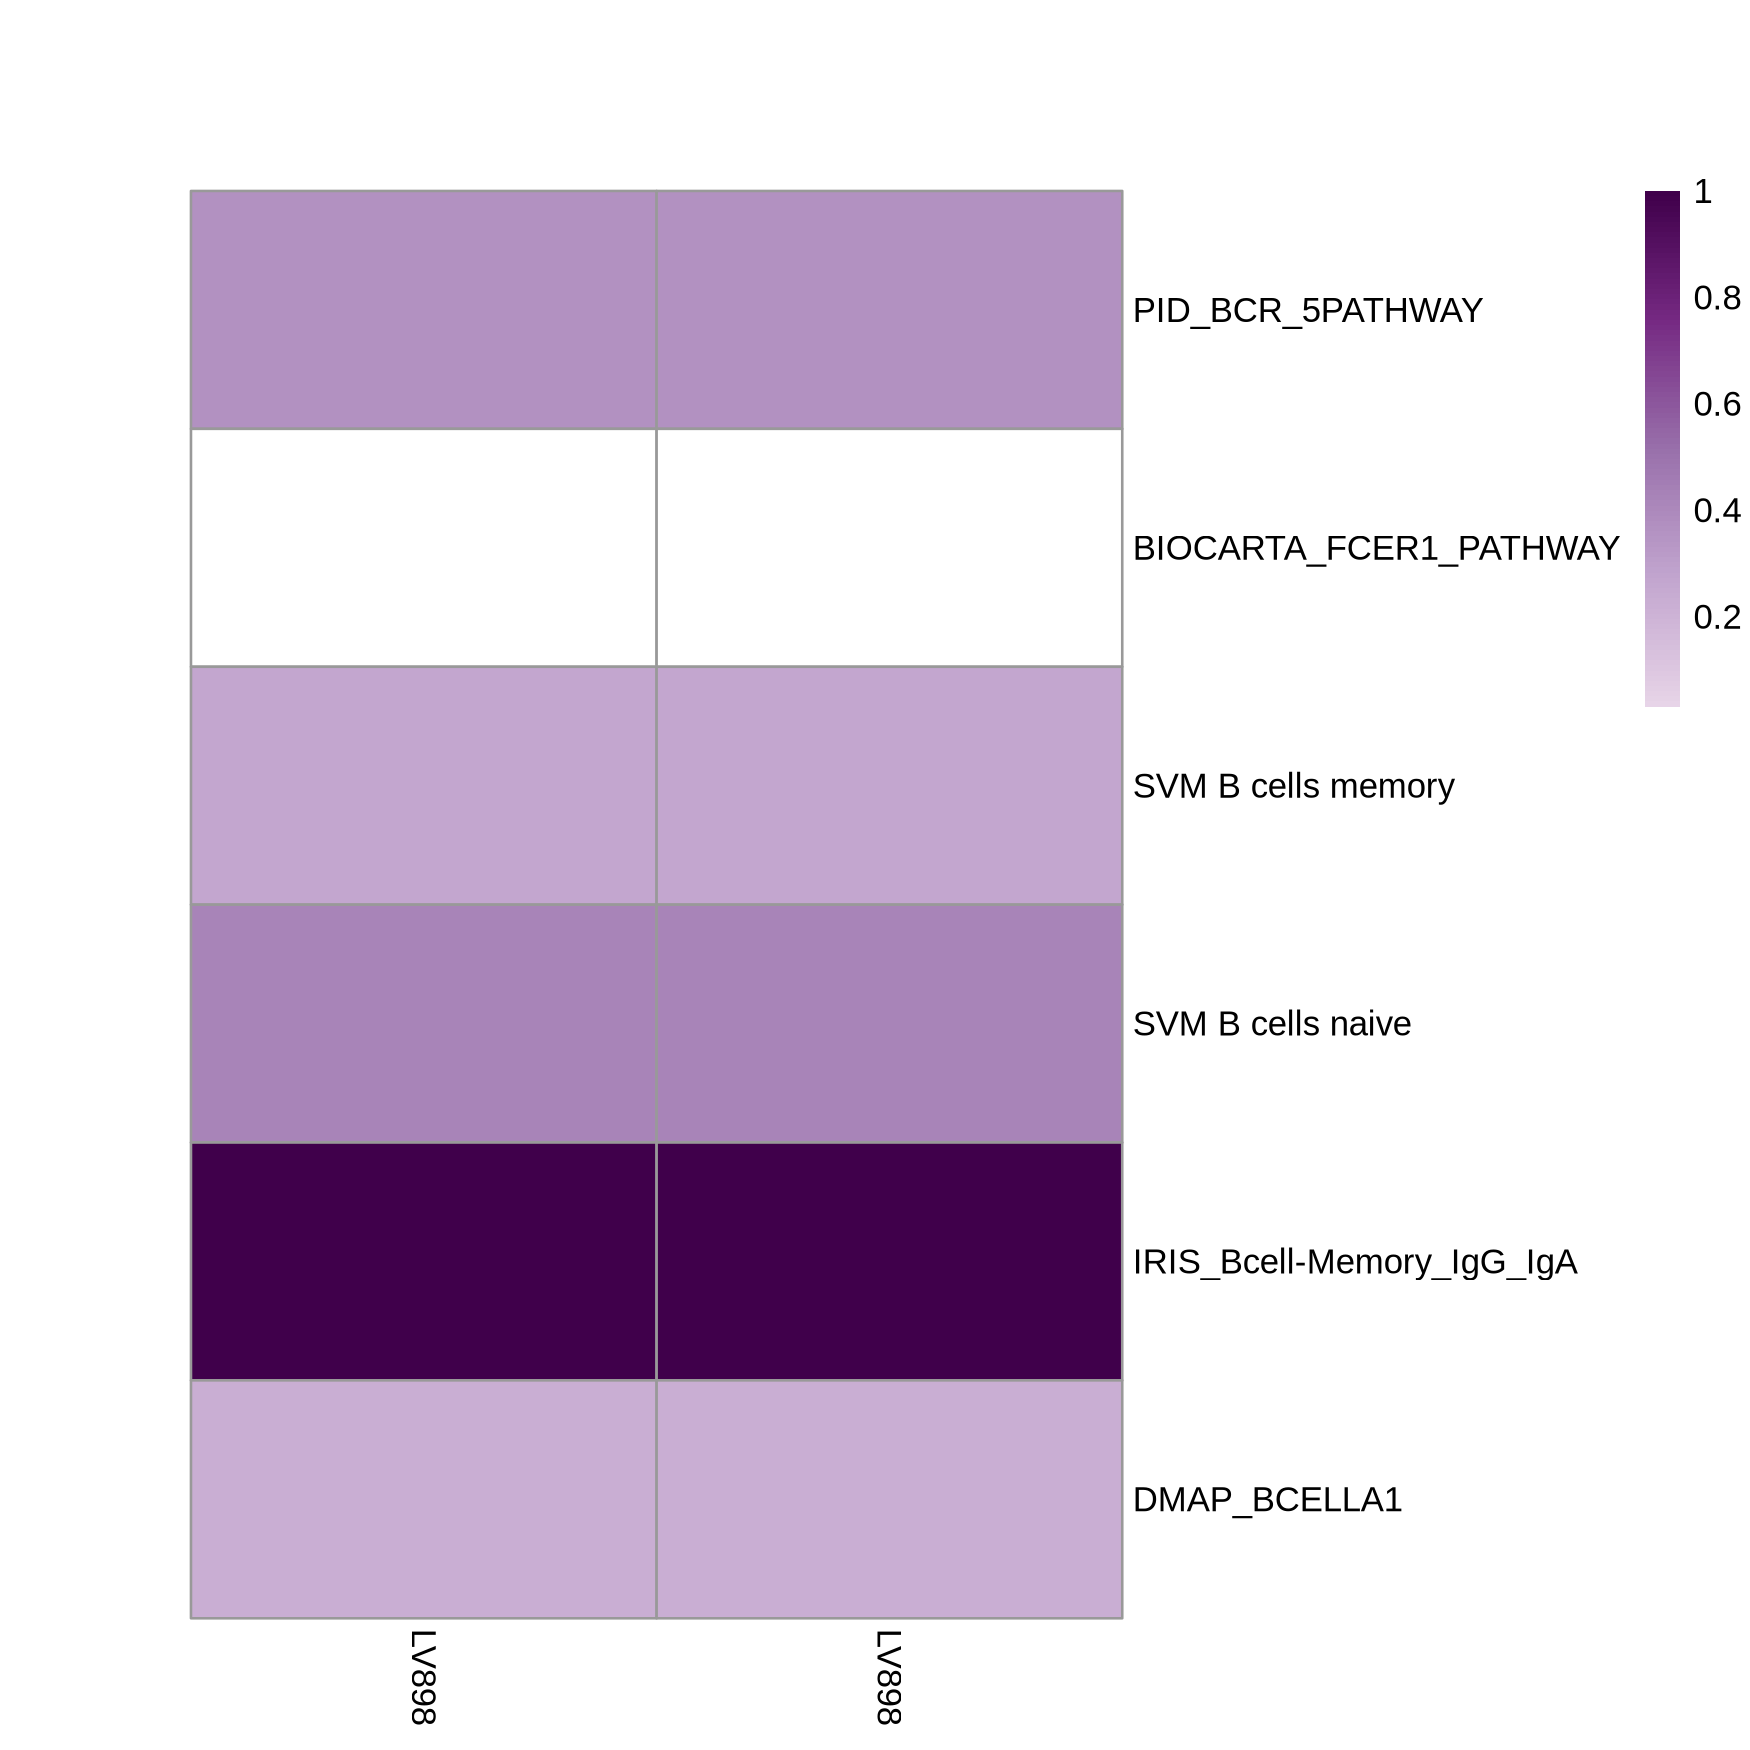

In [114]:
PLIER::plotU(plierRes = ordered_multiplier_model,
             indexCol = c(898, 898),
             top = 10)

In [43]:
head(top_int_lvs)

[1] "338" "967" "875" "149" "439" "52"

https://greenelab.github.io/multi-plier/03-isolated_cell_type_populations.nb.html

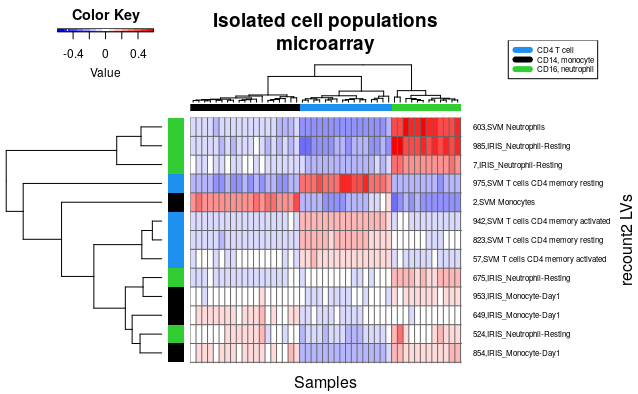

In [108]:
# Define the vector i_lv
i_lv <- first_10_lv_indices

# Extract numeric part from LV and create a new column for comparison
df_projection_GSE190125$LV_num <- as.numeric(sub(".*?(\\d+).*", "\\1", df_projection_GSE190125$LV))

# Subset the dataframe where LV_num matches the values in i_lv
df_selected <- df_projection_GSE190125[df_projection_GSE190125$LV_num %in% i_lv, ]

# Optionally, you can remove the temporary LV_num column
df_selected$LV_num <- NULL
df_projection_GSE190125$LV_num <- NULL

df_selected <- data.frame(df_selected)

# Reshape the data
long_data <- df_selected %>%
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
    dplyr::left_join(metadata_GSE190125)


ERROR: Error in `$<-.data.frame`(`*tmp*`, LV_num, value = numeric(0)): replacement has 0 rows, data has 987


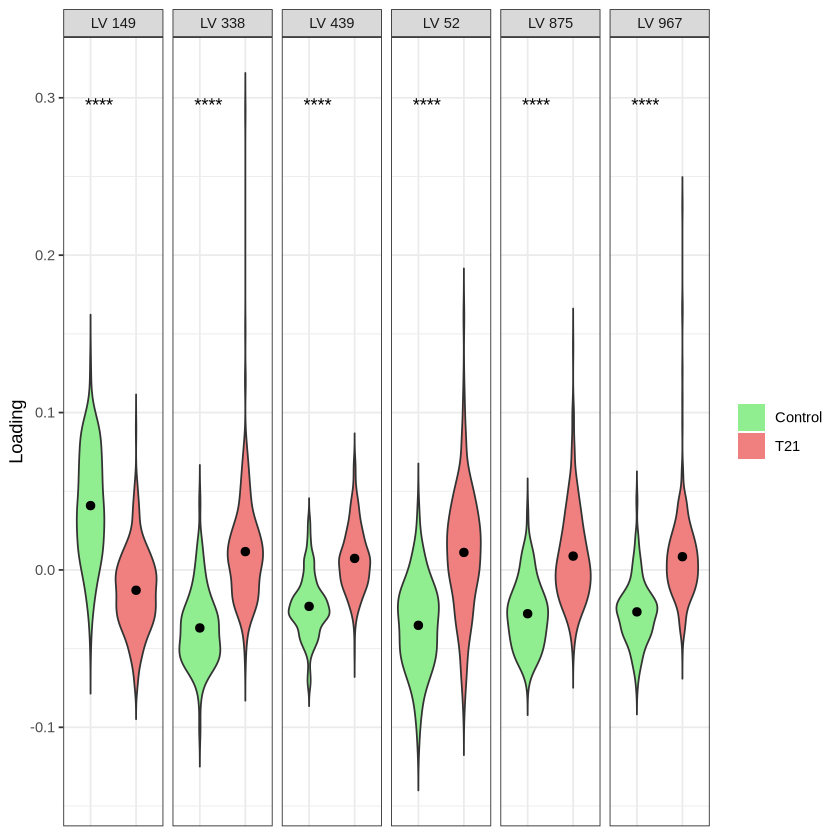

In [45]:
plot <- ggplot(long_data, aes(x = Group, y = Value, fill = Group)) +
    geom_violin(trim = FALSE) +
    stat_summary(fun = mean, geom = "point", color = "black", size = 2) +
    facet_grid(cols = vars(LV), scales = "free_x") +
    labs(x = NULL,  # Remove x-axis title
       y = "Loading") +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
         legend.title = element_blank()) +
        scale_fill_manual(values = c("Control" = "lightgreen", "T21" = "lightcoral")) 
# Add statistical test and modify the legend
plot <- plot + stat_compare_means(method = "wilcox.test", label = "p.signif")

# Add a custom legend entry for mean values
plot + guides(fill = guide_legend(override.aes = list(shape = c(NA, NA), linetype = c(0, 0))),
          color = guide_legend(override.aes = list(shape = c(16), linetype = c(0), color = "black"))) 

In [46]:
# genes vs lv sig (which genes are or not sig)
# log2FC or auc
# can genes separate the data?
# add traits
# recount2 B matrix subset
# enrichment chr21 